Starting simulation at t=0. s for a duration of 100. s
1.9858 s (1%) simulated in 10s, estimated 8m 14s remaining.
2.4511 s (2%) simulated in 20s, estimated 13m 16s remaining.
2.8589 s (2%) simulated in 30s, estimated 17m 0s remaining.
3.2309 s (3%) simulated in 40s, estimated 19m 58s remaining.
3.6417 s (3%) simulated in 50s, estimated 22m 3s remaining.
4.0295 s (4%) simulated in 1m 0s, estimated 23m 49s remaining.
4.3602 s (4%) simulated in 1m 10s, estimated 25m 36s remaining.
4.6469 s (4%) simulated in 1m 20s, estimated 27m 22s remaining.
4.9512 s (4%) simulated in 1m 30s, estimated 28m 48s remaining.
5.2829 s (5%) simulated in 1m 40s, estimated 29m 53s remaining.
5.6116 s (5%) simulated in 1m 50s, estimated 30m 51s remaining.
5.845 s (5%) simulated in 2m 0s, estimated 32m 13s remaining.
6.1223 s (6%) simulated in 2m 10s, estimated 33m 14s remaining.
6.4531 s (6%) simulated in 2m 20s, estimated 33m 50s remaining.
6.7683 s (6%) simulated in 2m 30s, estimated 34m 27s remaining.
7.0497

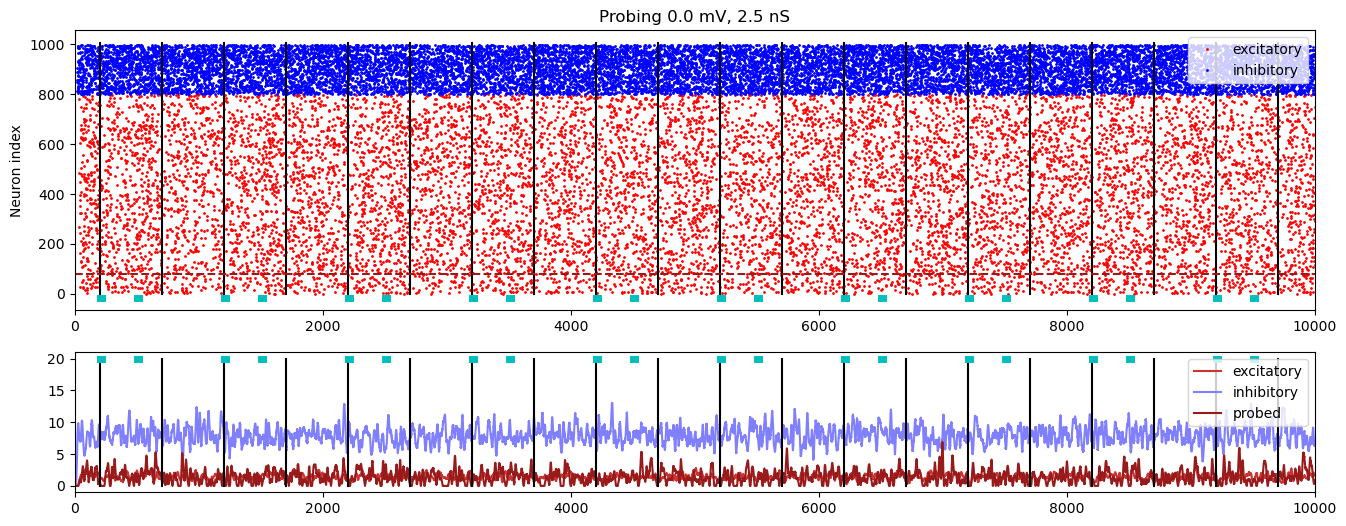

Saving results...
Starting simulation at t=0. s for a duration of 100. s
2.1097 s (2%) simulated in 10s, estimated 7m 44s remaining.
2.7326 s (2%) simulated in 20s, estimated 11m 52s remaining.
3.2096 s (3%) simulated in 30s, estimated 15m 5s remaining.
3.6376 s (3%) simulated in 40s, estimated 17m 40s remaining.
4.0386 s (4%) simulated in 50s, estimated 19m 48s remaining.
4.4334 s (4%) simulated in 1m 0s, estimated 21m 33s remaining.
4.8128 s (4%) simulated in 1m 10s, estimated 23m 5s remaining.
5.1512 s (5%) simulated in 1m 20s, estimated 24m 33s remaining.
5.4765 s (5%) simulated in 1m 30s, estimated 25m 54s remaining.
5.8244 s (5%) simulated in 1m 40s, estimated 26m 57s remaining.
6.1662 s (6%) simulated in 1m 50s, estimated 27m 54s remaining.
6.5216 s (6%) simulated in 2m 0s, estimated 28m 40s remaining.
6.8918 s (6%) simulated in 2m 10s, estimated 29m 17s remaining.
7.2723 s (7%) simulated in 2m 20s, estimated 29m 45s remaining.
7.6318 s (7%) simulated in 2m 30s, estimated 30m 16

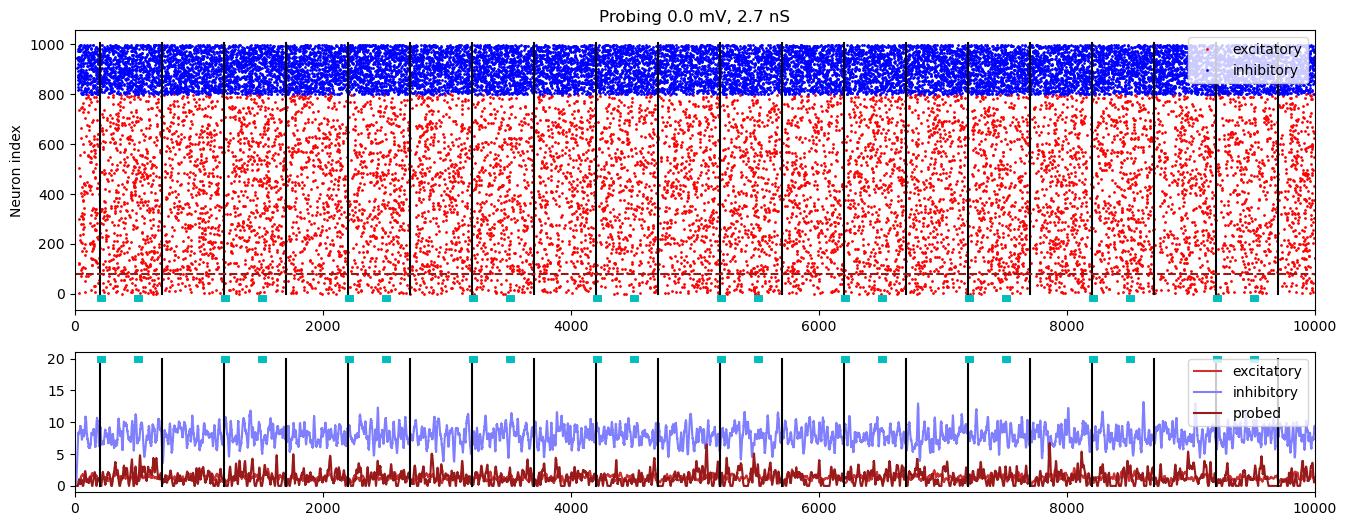

Saving results...
Starting simulation at t=0. s for a duration of 100. s
2.1314 s (2%) simulated in 10s, estimated 7m 39s remaining.
2.6769 s (2%) simulated in 20s, estimated 12m 7s remaining.
3.0959 s (3%) simulated in 30s, estimated 15m 39s remaining.
3.4935 s (3%) simulated in 40s, estimated 18m 25s remaining.
3.8834 s (3%) simulated in 50s, estimated 20m 38s remaining.
4.2589 s (4%) simulated in 1m 0s, estimated 22m 29s remaining.
4.6 s (4%) simulated in 1m 10s, estimated 24m 12s remaining.
4.9333 s (4%) simulated in 1m 20s, estimated 25m 42s remaining.
5.2493 s (5%) simulated in 1m 30s, estimated 27m 5s remaining.
5.5548 s (5%) simulated in 1m 40s, estimated 28m 20s remaining.
5.8614 s (5%) simulated in 1m 50s, estimated 29m 27s remaining.
6.1593 s (6%) simulated in 2m 0s, estimated 30m 29s remaining.
6.4498 s (6%) simulated in 2m 10s, estimated 31m 26s remaining.
6.7545 s (6%) simulated in 2m 20s, estimated 32m 13s remaining.
7.0757 s (7%) simulated in 2m 30s, estimated 32m 50s r

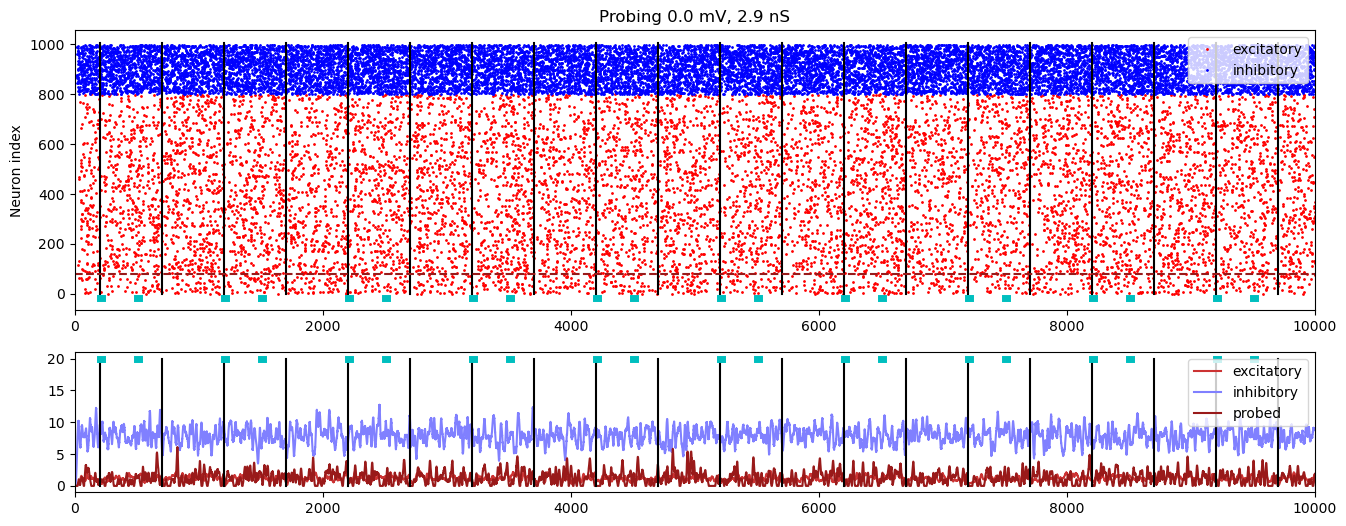

Saving results...
Starting simulation at t=0. s for a duration of 100. s
2.0356 s (2%) simulated in 10s, estimated 8m 1s remaining.
2.5653 s (2%) simulated in 20s, estimated 12m 40s remaining.
2.986 s (2%) simulated in 30s, estimated 16m 15s remaining.
3.3639 s (3%) simulated in 40s, estimated 19m 9s remaining.
3.7058 s (3%) simulated in 50s, estimated 21m 39s remaining.
4.0539 s (4%) simulated in 1m 0s, estimated 23m 40s remaining.
4.402 s (4%) simulated in 1m 10s, estimated 25m 20s remaining.
4.7184 s (4%) simulated in 1m 20s, estimated 26m 56s remaining.
5.0224 s (5%) simulated in 1m 30s, estimated 28m 22s remaining.
5.3324 s (5%) simulated in 1m 40s, estimated 29m 36s remaining.
5.6514 s (5%) simulated in 1m 50s, estimated 30m 37s remaining.
5.9653 s (5%) simulated in 2m 0s, estimated 31m 32s remaining.
6.2821 s (6%) simulated in 2m 10s, estimated 32m 20s remaining.
6.5973 s (6%) simulated in 2m 20s, estimated 33m 2s remaining.
6.9246 s (6%) simulated in 2m 30s, estimated 33m 36s r

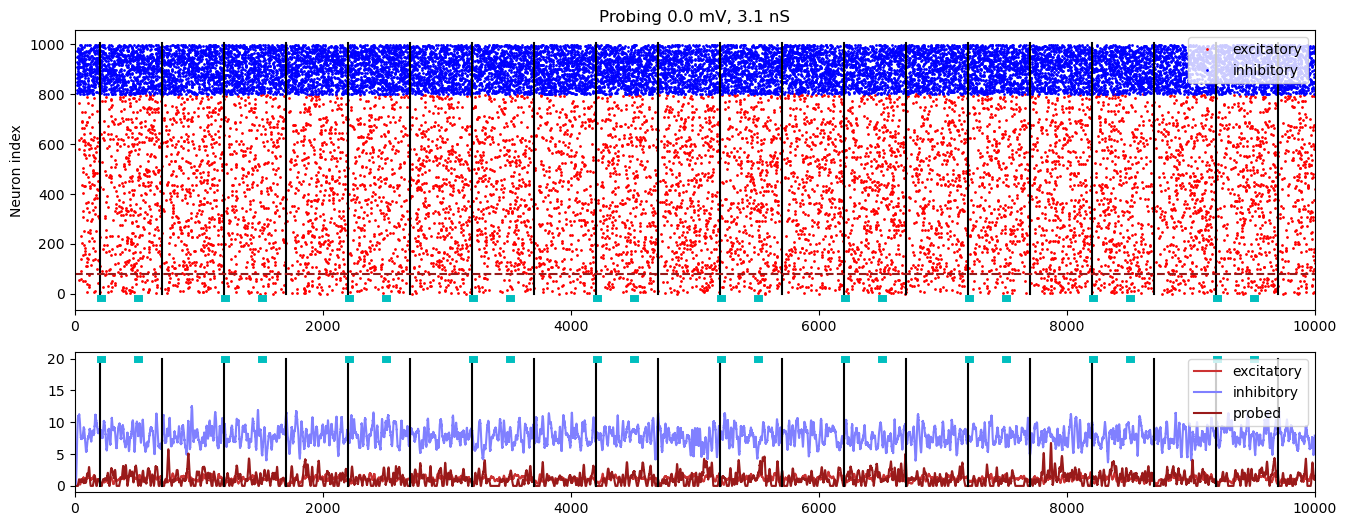

Saving results...
Starting simulation at t=0. s for a duration of 100. s
2.1103 s (2%) simulated in 10s, estimated 7m 44s remaining.
2.6672 s (2%) simulated in 20s, estimated 12m 10s remaining.
3.1118 s (3%) simulated in 30s, estimated 15m 34s remaining.
3.4788 s (3%) simulated in 40s, estimated 18m 30s remaining.
3.8195 s (3%) simulated in 50s, estimated 20m 59s remaining.
4.1344 s (4%) simulated in 1m 0s, estimated 23m 11s remaining.
4.4363 s (4%) simulated in 1m 10s, estimated 25m 8s remaining.
4.7362 s (4%) simulated in 1m 20s, estimated 26m 49s remaining.
5.0348 s (5%) simulated in 1m 30s, estimated 28m 18s remaining.
5.336 s (5%) simulated in 1m 40s, estimated 29m 34s remaining.
5.6325 s (5%) simulated in 1m 50s, estimated 30m 43s remaining.
5.9289 s (5%) simulated in 2m 0s, estimated 31m 44s remaining.
6.2086 s (6%) simulated in 2m 10s, estimated 32m 44s remaining.
6.4727 s (6%) simulated in 2m 20s, estimated 33m 43s remaining.
6.7382 s (6%) simulated in 2m 30s, estimated 34m 36

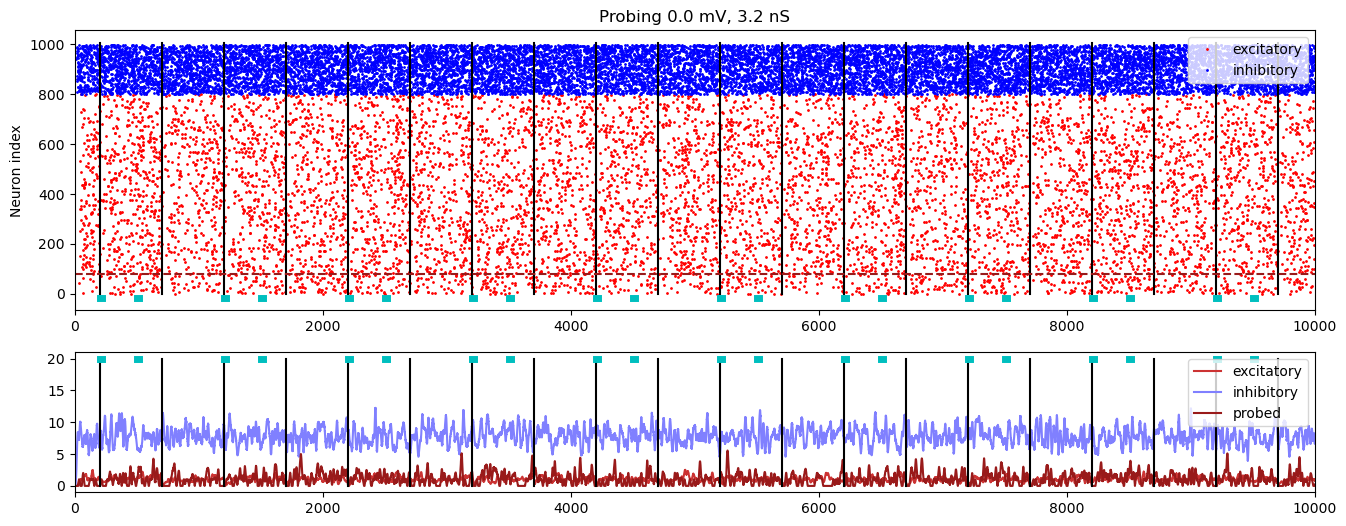

Saving results...
Starting simulation at t=0. s for a duration of 100. s
2.0224 s (2%) simulated in 10s, estimated 8m 5s remaining.
2.5071 s (2%) simulated in 20s, estimated 12m 58s remaining.
2.8737 s (2%) simulated in 30s, estimated 16m 54s remaining.
3.2178 s (3%) simulated in 40s, estimated 20m 3s remaining.
3.5506 s (3%) simulated in 50s, estimated 22m 38s remaining.
3.87 s (3%) simulated in 1m 0s, estimated 24m 51s remaining.
4.1726 s (4%) simulated in 1m 10s, estimated 26m 48s remaining.
4.4661 s (4%) simulated in 1m 20s, estimated 28m 32s remaining.
4.7453 s (4%) simulated in 1m 30s, estimated 30m 7s remaining.
5.0213 s (5%) simulated in 1m 40s, estimated 31m 32s remaining.
5.2972 s (5%) simulated in 1m 50s, estimated 32m 47s remaining.
5.5683 s (5%) simulated in 2m 0s, estimated 33m 55s remaining.
5.8261 s (5%) simulated in 2m 10s, estimated 35m 2s remaining.
6.0861 s (6%) simulated in 2m 20s, estimated 36m 1s remaining.
6.3388 s (6%) simulated in 2m 30s, estimated 36m 57s rem

In [ ]:
# based on Brunel and Wang 2001

from brian2 import *
import time, os
import pandas as pd

start_scope()
clear_cache('cython')

# Model parameters
save_results = True
save_results_path = "C:/Users/mvalero/Dropbox/DATA/" # C:\Users\mvalero\Dropbox\DATA/   /Users/manu/Dropbox/DATA/
results_folder_name = "monoSynBition_models_100s_PC/"
save_results_path = os.path.join(save_results_path, results_folder_name)
try:
    os.mkdir(save_results_path)
except OSError as error:
    print(error)    

probing_mV_increment = linspace(0, 20, 41) # [6, 7]
GABA_factor = linspace(2, 8, 41) # [4, 5];                              #
probing_stim_duration = 20 # in ms
probing_stimulation_times = []
for ii in range(100):
    probing_stimulation_times.append(ii * 1000 + 201)
    probing_stimulation_times.append(ii * 1000 + 501)
inhibition_times = []
for ii in range(100):
    inhibition_times.append(ii * 1000 + 201)
    inhibition_times.append(ii * 1000 + 701)
duration = 100

# populations
N = 1000
N_E = int(N * 0.8)  # pyramidal neurons
N_I = int(N * 0.2)  # interneurons
N_E_probed = N_E * 0.1 # optogenetic probing in 10% of the population of pyramidal cells
N_E_probed = int(N_E_probed)

# voltage
V_L = -70. * mV
V_thr_E = -50. * mV
V_thr_I = -50 * mV
V_reset = -55. * mV
V_E = 0. * mV
V_I = -70. * mV

# membrane capacitance
C_m_E = 0.5 * nF
C_m_I = 0.2 * nF

# membrane leak
g_m_E = 25. * nS
g_m_I = 20. * nS

# refractory period
tau_rp_E = 2. * ms
tau_rp_I = 1. * ms

# external stimuli
rate = 3 * Hz
C_ext = 800

# synapses
C_E = N_E
C_I = N_I

# AMPA (excitatory)
g_AMPA_ext_E = 2.08 * nS
g_AMPA_rec_E = 0.104 * nS * 800. / N_E
g_AMPA_ext_I = 1.62 * nS
g_AMPA_rec_I = 0.081 * nS * 800. / N_E
tau_AMPA = 2. * ms

# NMDA (excitatory)
g_NMDA_E = 0.327 * nS * 800. / N_E
g_NMDA_I = 0.258 * nS * 800. / N_E
tau_NMDA_rise = 2. * ms
tau_NMDA_decay = 100. * ms
alpha = 0.5 / ms
Mg2 = 1.

# GABAergic (inhibitory)
# g_GABA_E = GABA_factor * 1.25 * nS * 200. / N_I
g_GABA_I = 0.973 * nS * 200. / N_I
tau_GABA = 15. * ms

# probing stimulation
# probing_stimulation = TimedArray(np.r_[np.zeros(200), np.ones(20)*probing_mV_increment, np.zeros(280), np.ones(20)*probing_mV_increment, np.zeros(500)]*mV, 1 * ms)

# modeling
eqs_E = '''
dv / dt = (- g_m_E * (v - V_L - probing_stimulation(t)*int(i<=N_E_probed)) - I_syn) / C_m_E: volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_E * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_E * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot : 1

I_GABA_rec = g_GABA_E * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1
'''

eqs_I = '''
dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_I * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_I * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot : 1

I_GABA_rec = g_GABA_I * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1
'''

P_E = NeuronGroup(N_E, eqs_E, threshold='v > V_thr_E', reset='v = V_reset', refractory=tau_rp_E, method='euler')
P_E.v = V_L
P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr_I', reset='v = V_reset', refractory=tau_rp_I, method='euler')
P_I.v = V_L
indices = np.zeros(len(inhibition_times))
times = array(inhibition_times)*ms
P_I_probed = SpikeGeneratorGroup(1, indices.astype(int), times)

eqs_glut = '''
s_NMDA_tot_post = w * s_NMDA : 1 (summed)
ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
w : 1
'''

eqs_pre_glut = '''
s_AMPA += w
x += 1
'''

eqs_pre_gaba = '''
s_GABA += 1
'''

eqs_pre_gaba_probing = '''
s_GABA += 1
'''

eqs_pre_ext = '''
s_AMPA_ext += 1
'''

# E to E
C_E_E = Synapses(P_E, P_E, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')
C_E_E.connect('i != j', p=0.0)

# E to I
C_E_I = Synapses(P_E, P_I, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')
C_E_I.connect('i != j', p=0.2)

# I to I
C_I_I = Synapses(P_I, P_I, on_pre=eqs_pre_gaba, method='euler')
C_I_I.connect('i != j', p=0.05)

# I to E
C_I_E = Synapses(P_I, P_E, on_pre=eqs_pre_gaba, method='euler')
C_I_E.connect('i != j', p=0.05)

# I_probed to E
C_I_probed_E = Synapses(P_I_probed, P_E, on_pre=eqs_pre_gaba_probing, method='euler')
#C_I_probed_E.connect(condition = 'j<N_E_probed * 2')
I_probed_connected_pyramidal = np.arange(N_E_probed + N_E_probed)
#C_I_probed_E.connect(i = 0, j = I_probed_connected_pyramidal.astype(int))
C_I_probed_E.connect()

# external noise
C_P_E = PoissonInput(P_E, 's_AMPA_ext', C_ext, rate, '.85')
C_P_I = PoissonInput(P_I, 's_AMPA_ext', C_ext, rate, '.85')

# monitors
sp_E = SpikeMonitor(P_E)
sp_I = SpikeMonitor(P_I)
sp_E_probed = SpikeMonitor(P_I_probed)
mon=StateMonitor(P_E, 'v', record=True)

# r_E_sels = [PopulationRateMonitor(P_E[pi:pi + N_sub]) for pi in range(N_non, N_non + p * N_sub, N_sub)]
r_E = PopulationRateMonitor(P_E)
r_E_probed = PopulationRateMonitor(P_E[0:N_E_probed])
r_E_non_probed = PopulationRateMonitor(P_E[N_E_probed:])
r_I = PopulationRateMonitor(P_I)

# simulate
net = Network(collect())
net.store()
for probing_steps in probing_mV_increment:
    for GABA_factor_steps in GABA_factor:
        # probing stimulation
        probing_stimulation = np.r_[np.zeros(duration*1000)]
        for pulses in probing_stimulation_times:
            probing_stimulation[pulses:pulses+probing_stim_duration] = probing_steps
        probing_stimulation = TimedArray(probing_stimulation*mV, 1 * ms)
    
        # GABAergic (inhibitory)
        g_GABA_E = GABA_factor_steps * 1.25 * nS * 200. / N_I
        
        # running
        net.restore()
        net.run(duration * second, report='stdout')

        # plotting
        fig1 = plt.figure(figsize=(16, 6))
        gs = GridSpec(2, 1, height_ratios=[4, 2])
        ax0 = fig1.add_subplot(gs[0])               # axis 0 raster
        ax1 = fig1.add_subplot(gs[1],sharex=ax0)    # axis 1 firing rate
        
        ax0.plot(sp_E.t / ms, sp_E.i, 'r.', markersize=2)
        ax0.plot(sp_I.t / ms, sp_I.i + N * 0.8, 'b.', markersize=2)
        for inh_spk in inhibition_times:
            ax0.plot([inh_spk, inh_spk],[0, N+5],'k')
        for prob_times in probing_stimulation_times:
            ax0.plot([prob_times, prob_times+probing_stim_duration],[-15, -15],'c',linewidth=5)
        ax0.plot([0, duration*1000],[N_E_probed, N_E_probed],'--',color=[.6, .1, .1])
        ax0.set_title('Probing ' + str(probing_steps) + ' mV, ' + str(round(GABA_factor_steps * 1.25,1)) + ' nS')
        ax0.set_ylabel('Neuron index')
        ax0.set_xlim(0,10000)
        ax0.legend(['excitatory', 'inhibitory'],loc = 'upper right')
        
        ax1.plot(r_E.t / ms, r_E_non_probed.smooth_rate(width=5 * ms) / Hz, label='excitatory', color=[.8, .2, .2])
        ax1.plot(r_I.t / ms, r_I.smooth_rate(width=5 * ms) / Hz, label='inhibitory', color=[.5, .5, 1])
        ax1.plot(r_E_probed.t / ms, r_E_probed.smooth_rate(width=5 * ms) / Hz, label='probed', color=[.6, .1, .1])
        #for inh_spk in inhibition_times:
        #    ax0.plot([inh_spk, inh_spk],[0, 20],'k')
        for inh_spk in inhibition_times:
            ax1.plot([inh_spk, inh_spk],[0, 20],'k')
        for prob_times in probing_stimulation_times:
            ax1.plot([prob_times, prob_times+probing_stim_duration],[20, 20],'c',linewidth=5)
        ax1.set_xlim(0,10000)
        ax1.legend(['excitatory', 'inhibitory','probed'],loc = 'upper right')
        show()
        
        # Save recording
        if save_results:
            print('Saving results...')
            sim_name = 'sim ' + time.asctime() # Simulation name 
            sim_name = sim_name.replace(' ','_')
            sim_name = sim_name.replace(':','_')
            sim_name = save_results_path + sim_name
            os.mkdir(sim_name) # creating simulation folder

            fig1.savefig(sim_name + '/summary.png')   # save the figure to file

            spk_E = pd.DataFrame([list(sp_E.i), list(sp_E.t/ms)])                       # saving E spikes
            spk_E.to_csv(sim_name + '/spk_E.csv', sep=',', encoding='utf-8', index=False, header=False)

            spk_I = pd.DataFrame([list(sp_I.i), list(sp_I.t/ms)])                       # saving I spikes
            spk_I.to_csv(sim_name + '/spk_I.csv', sep=',', encoding='utf-8', index=False, header=False)

            spk_E_probed = pd.DataFrame([list(sp_E_probed.i), list(sp_E_probed.t/ms)])  # saving I probed spikes
            spk_E_probed.to_csv(sim_name + '/spk_E_probed.csv', sep=',', encoding='utf-8', index=False, header=False)

            # Save connectivity
            CE_E = pd.DataFrame([list(C_E_E.i), list(C_E_E.j)]) # E to E matrix connection
            CE_E.to_csv(sim_name + '/CE_E.csv', sep=',', encoding='utf-8', index=False, header=False)
        
            CE_I = pd.DataFrame([list(C_E_I.i), list(C_E_I.j)]) # E to I matrix connection
            CE_I.to_csv(sim_name + '/CE_I.csv', sep=',', encoding='utf-8', index=False, header=False)
        
            CI_E = pd.DataFrame([list(C_I_E.i), list(C_I_E.j)]) # I to E matrix connection
            CI_E.to_csv(sim_name + '/CI_E.csv', sep=',', encoding='utf-8', index=False, header=False)
        
            CI_I = pd.DataFrame([list(C_I_I.i), list(C_I_I.j)]) # I to I matrix connection
            CI_I.to_csv(sim_name + '/CI_I.csv', sep=',', encoding='utf-8', index=False, header=False)

            CI_probed_E = pd.DataFrame([list(C_I_probed_E.i), list(C_I_probed_E.j)]) # I probed to E matrix connection
            CI_probed_E.to_csv(sim_name + '/CI_probed_E.csv', sep=',', encoding='utf-8', index=False, header=False)

            # Save features
            feat = pd.DataFrame([N_E,N_I,N_E_probed,duration,V_L/mV,V_thr_E/mV,V_thr_I/mV,V_reset/mV,
                                V_E/mV,V_I/mV,C_m_E/nF,C_m_I/pF,g_m_E/nS,g_m_I/nS,
                                tau_rp_E/ms,tau_rp_I/ms,rate/Hz,C_ext,GABA_factor_steps,probing_steps,probing_stim_duration])
            feat.to_csv(sim_name + '/features.csv', sep=',', encoding='utf-8', index=False, header=False)

            # Save stimulation times
            stim_times = pd.DataFrame(list(probing_stimulation_times))
            stim_times.to_csv(sim_name + '/probing_times.csv', sep=',', encoding='utf-8', index=False, header=False)

            # Save inhibition times
            inh_times = pd.DataFrame(list(inhibition_times))
            inh_times.to_csv(sim_name + '/inhibition_times.csv', sep=',', encoding='utf-8', index=False, header=False)

print('Done')